## Example using Histone modification data downloaded from Encode

In [8]:
import pandas as pd
import numpy as np
from scivae import VAE

# Set the location of the mnist data
data_dir ='../tests/data/'
df = pd.read_csv(f'{data_dir}mouse_HM_var500_data.csv')
df 

,entrezgene_id,external_gene_name,ensembl_gene_id,embryonic-facial-prominence_10.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF003VMR_width,embryonic-facial-prominence_10.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF003VMR_signal,embryonic-facial-prominence_10.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF310NGB_width,embryonic-facial-prominence_10.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF310NGB_signal,embryonic-facial-prominence_10.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF565QAD_width,embryonic-facial-prominence_10.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF565QAD_signal,embryonic-facial-prominence_10.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF053GHW_width,...,stomach_16.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF814BNR_width,stomach_16.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF814BNR_signal,stomach_16.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF501CJA_width,stomach_16.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF501CJA_signal,stomach_16.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF569KWB_width,stomach_16.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF569KWB_signal,stomach_16.5-days_embryonic_H3K9ac_ChIP-seq_ENCFF068FWP_width,stomach_16.5-days_embryonic_H3K9ac_ChIP-seq_ENCFF068FWP_signal,stomach_16.5-days_embryonic_H3K9me3_ChIP-seq_ENCFF544RGQ_width,stomach_16.5-days_embryonic_H3K9me3_ChIP-seq_ENCFF544RGQ_signal
0,497097,Xkr4,ENSMUSG00000051951,838.0,4.64805,2236.0,4.70623,NaN,NaN,841.0,...,459.0,4.17547,2522.0,32.56543,2456.0,37.44113,1852.0,6.81303,NaN,NaN
1,384198,Fam47e,ENSMUSG00000057068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12492,Scarb2,ENSMUSG00000029426,2053.0,16.06083,NaN,NaN,4699.0,4.03960,787.0,...,797.0,4.94311,862.0,20.08811,3071.0,61.25575,2503.0,24.87381,NaN,NaN
3,269113,Nup54,ENSMUSG00000034826,1546.0,23.33510,NaN,NaN,8433.0,4.30511,462.0,...,215.0,2.45555,1376.0,35.42474,2128.0,66.67310,1165.0,28.39603,425.0,3.4231
4,15945,Cxcl10,ENSMUSG00000034855,NaN,NaN,984.0,4.95978,NaN,NaN,1086.0,...,641.0,3.41532,794.0,13.95355,661.0,8.53067,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20395,21762,Psmd2,ENSMUSG00000006998,1431.0,10.42818,NaN,NaN,4157.0,3.39655,1512.0,...,NaN,NaN,1407.0,13.44737,1765.0,61.31395,1525.0,20.17010,NaN,NaN
20396,73047,Camk2n2,ENSMUSG00000051146,2117.0,10.87675,3875.0,5.10808,734.0,3.56510,3664.0,...,656.0,4.96696,3348.0,26.86646,3417.0,25.29333,1863.0,7.71053,NaN,NaN
20397,107522,Ece2,ENSMUSG00000022842,1041.0,7.72166,3514.0,5.33374,NaN,NaN,1335.0,...,301.0,2.85033,1312.0,30.50417,1046.0,31.87724,926.0,10.12819,NaN,NaN
20398,208624,Alg3,ENSMUSG00000033809,2342.0,17.18692,NaN,NaN,754.0,5.22586,1288.0,...,NaN,NaN,3259.0,44.11346,2597.0,66.85134,834.0,9.84724,NaN,NaN


## Normalise the data

Before running the VAE we might only want to do it on a subset, here I'm interested in marks at day E10.5 
only in the brain.

In [2]:
df = df.fillna(0)
# Get out columns with HM values
cols = [c for c in df.columns if '10' in c and 'brain' in c and 'signal' in c]  # i.e. only do brain at E10 samples
# Make sure we log2 the values since they're too diffuse
vae_df = pd.DataFrame()
vae_df['external_gene_name'] = df['external_gene_name'].values
new_cols = []
for c in cols:
    new_name = ' '.join(c.split('_')[:-3]).replace('embryonic', '')
    new_cols.append(new_name)
    vae_df[new_name] = np.log2(df[c] + 1)

dataset = vae_df[new_cols].values
# Create and train VAE

## Train the VAE

We run the training of the VAE 

In [3]:
config = {"loss":
  {"loss_type": "mse",
    "distance_metric": "mmd",
    "mmd_weight": 1.0
  },
  "encoding": {
    "layers": [
      {"num_nodes": 64, "activation_fn": "relu"},
                {"num_nodes": 32, "activation_fn": "selu"}
        ]
  },
  "decoding": {
    "layers": [
                {"num_nodes": 32, "activation_fn": "selu"},
                {"num_nodes": 64, "activation_fn": "relu"}
        ]
  },
  "latent": {
    "num_nodes": 3
  },
  "optimiser": {
    "params": {"learning_rate": 0.001, "beta_1": 0.8, "beta_2": 0.97},
    "name": "adamax"
  }
}

vae = VAE(dataset, dataset, ["None"] * len(dataset), config, f'vae_rcm')
vae.encode('default', epochs=10, batch_size=50)

None
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 22)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           1472        default_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            99          dense_1[0][0]                    
_______________________________________________________________________________________

347/347 [==============================] - 2s 2ms/step - loss: 1.1899 - val_loss: 0.5001
Epoch 2/10
347/347 [==============================] - 0s 1ms/step - loss: 0.4240 - val_loss: 0.3892
Epoch 3/10
347/347 [==============================] - 0s 1ms/step - loss: 0.3651 - val_loss: 0.3549
Epoch 4/10
347/347 [==============================] - 0s 1ms/step - loss: 0.3384 - val_loss: 0.3371
Epoch 5/10
347/347 [==============================] - 0s 1ms/step - loss: 0.3229 - val_loss: 0.3246
Epoch 6/10
347/347 [==============================] - 0s 1ms/step - loss: 0.3098 - val_loss: 0.3125
Epoch 7/10
347/347 [==============================] - 0s 1ms/step - loss: 0.2989 - val_loss: 0.2984
Epoch 8/10
347/347 [==============================] - 0s 1ms/step - loss: 0.2916 - val_loss: 0.2985
Epoch 9/10
347/347 [==============================] - 0s 1ms/step - loss: 0.2853 - val_loss: 0.2906
Epoch 10/10
347/347 [==============================] - 0s 1ms/step - loss: 0.2823 - val_loss: 0.2934


## Quality control!

Check that the nodes follow **approximately** a normal distribution.

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


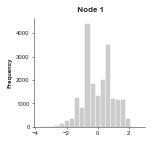

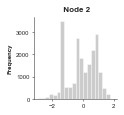

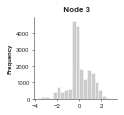

<Figure size 108x108 with 0 Axes>

In [4]:
from scivae import Vis

vis = Vis(vae, vae.u, None)
vis.plot_node_hists(show_plt=True, save_fig=False)

## Quality control 2: Visualise the correlation between features.

Since the VAE isn't magic, just good at learning correlations/patterns between input features, it's sensible 
to check that the correlations between features and nodes exists.

1 forebrain 10.5-days  H3K27ac 0.4646790949175706 0.0
1 forebrain 10.5-days  H3K27me3 -0.15472023269738114 1.7186809987857506e-109
1 forebrain 10.5-days  H3K36me3 0.7034915399250475 0.0
1 forebrain 10.5-days  H3K4me1 0.2374318904276696 2.2691830385786743e-259
1 forebrain 10.5-days  H3K4me3 0.4267130168570907 0.0
1 forebrain 10.5-days  H3K9me3 0.3715109653519765 0.0
1 forebrain 13.5-days  H3K36me3 0.7536177586683842 0.0
1 forebrain 16.5-days  H3K9ac 0.4311244656756008 0.0
1 hindbrain 10.5-days  H3K27ac 0.4641502258490996 0.0
1 hindbrain 10.5-days  H3K27me3 -0.163304181021595 6.399773452221439e-122
1 hindbrain 10.5-days  H3K36me3 0.7202589484281038 0.0
1 hindbrain 10.5-days  H3K4me1 0.22426942313825166 6.532753007090467e-231
1 hindbrain 10.5-days  H3K4me3 0.43126634517147616 0.0
1 hindbrain 10.5-days  H3K9me3 0.33884187831715556 0.0
1 hindbrain 16.5-days  H3K36me3 0.7743244209616199 0.0
1 midbrain 10.5-days  H3K27ac 0.4686971257013068 0.0
1 midbrain 10.5-days  H3K27me3 -0.153160244305111

<Figure size 108x108 with 0 Axes>

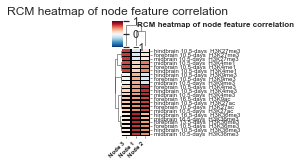

,Node 1,Node 1 padj,Node 2,Node 2 padj,Node 3,Node 3 padj,labels
0,0.464679,0.0,0.682359,0.0,0.244783,0.000,forebrain 10.5-days H3K27ac
1,-0.154720,0.0,0.104831,0.0,0.703051,0.000,forebrain 10.5-days H3K27me3
2,0.703492,0.0,0.479535,0.0,0.054240,0.000,forebrain 10.5-days H3K36me3
3,0.237432,0.0,0.485404,0.0,0.659877,0.000,forebrain 10.5-days H3K4me1
4,0.426713,0.0,0.730727,0.0,0.220802,0.000,forebrain 10.5-days H3K4me3
5,0.371511,0.0,-0.186520,0.0,-0.024246,0.001,forebrain 10.5-days H3K9me3
6,0.753618,0.0,0.427734,0.0,0.071664,0.000,forebrain 13.5-days H3K36me3
7,0.431124,0.0,0.668830,0.0,0.292447,0.000,forebrain 16.5-days H3K9ac
8,0.464150,0.0,0.682435,0.0,0.259965,0.000,hindbrain 10.5-days H3K27ac
9,-0.163304,0.0,0.083594,0.0,0.697394,0.000,hindbrain 10.5-days H3K27me3


<Figure size 216x144 with 0 Axes>

In [5]:
vis.plot_node_feature_correlation(vae_df, 'external_gene_name', columns=new_cols, show_plt=True, save_fig=False)

## Having fun with inspecting the latent space

Now we are confident it's learnt stuff, let's look at how all our genes look on the latent space!

No handles with labels found to put in legend.


<Figure size 144x144 with 0 Axes>

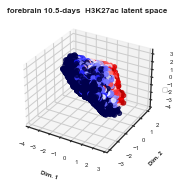

No handles with labels found to put in legend.


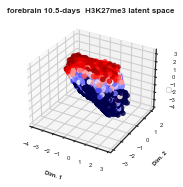

No handles with labels found to put in legend.


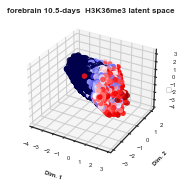

No handles with labels found to put in legend.


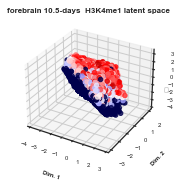

No handles with labels found to put in legend.


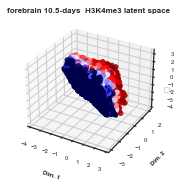

No handles with labels found to put in legend.


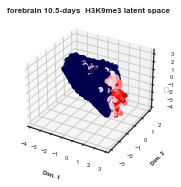

No handles with labels found to put in legend.


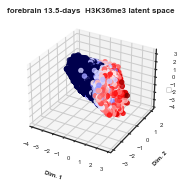

No handles with labels found to put in legend.


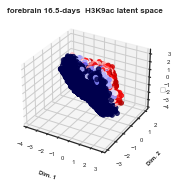

No handles with labels found to put in legend.


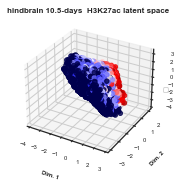

No handles with labels found to put in legend.


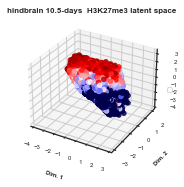

No handles with labels found to put in legend.


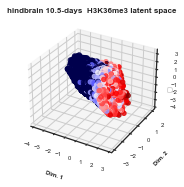

No handles with labels found to put in legend.


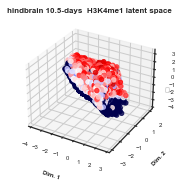

No handles with labels found to put in legend.


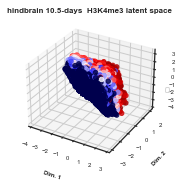

No handles with labels found to put in legend.


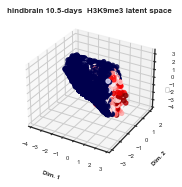

No handles with labels found to put in legend.


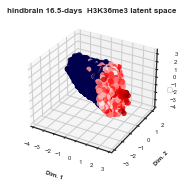

No handles with labels found to put in legend.


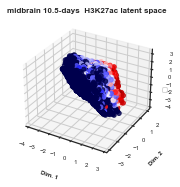

No handles with labels found to put in legend.


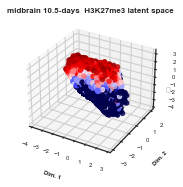

No handles with labels found to put in legend.


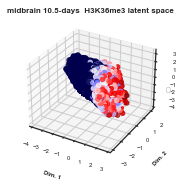

No handles with labels found to put in legend.


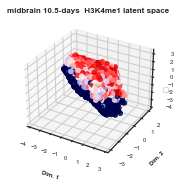

No handles with labels found to put in legend.


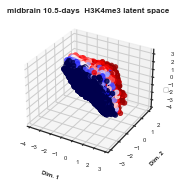

No handles with labels found to put in legend.


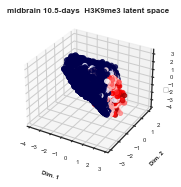

No handles with labels found to put in legend.


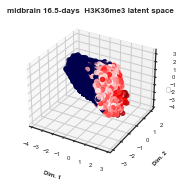

In [6]:
vis.plot_feature_scatters(vae_df, 'external_gene_name', columns=new_cols, show_plt=True, fig_type="png", 
                          save_fig=False,
                          title="latent space")


## Plot specific genes

Since we love certain genes, lets have a look at where they are on the latent space

<Figure size 144x144 with 0 Axes>

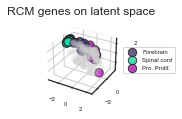

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

In [7]:
cool_genes = [['Emx1', 'Eomes', 'Tbr1', 'Foxg1', 'Lhx6', 'Arx', 'Dlx1', 'Dlx2', 'Dlx5', 'Nr2e2', 'Otx2'],
              ['Hoxd8', 'Hoxd9', 'Hoxd10', 'Hoxd11', 'Hoxd12', 'Hoxd13', 'Hoxa7', 'Hoxa9', 'Hoxa10', 'Hoxa11',
              'Hoxa13',
              'Hoxb9', 'Hoxb13', 'Hoxc8', 'Hoxc9', 'Hoxc10', 'Hoxc11', 'Hoxc12', 'Hoxc13'],
              ['Ccna1', 'Ccna2', 'Ccnd1', 'Ccnd2', 'Ccnd3', 'Ccne1', 'Ccne2', 'Cdc25a',
               'Cdc25b', 'Cdc25c', 'E2f1', 'E2f2', 'E2f3', 'Mcm10', 'Mcm5', 'Mcm3', 'Mcm2', 'Cip2a']
              ]

vis.plot_values_on_scatters(vae_df, "external_gene_name", ['Forebrain', 'Spinal cord', 'Pro. Prolif.'],
                            cool_genes, show_plt=True, fig_type=".png",
                            save_fig=False)
        